In [1]:
import os
import sys

module_path = os.path.abspath(os.path.join('../../..'))

if module_path not in sys.path:
    print(f"Adding [{module_path}] to sys.path")
    sys.path.append(module_path)

In [2]:
import logging
logging.basicConfig(level=logging.WARN)

import pathlib
from copy import copy

import gym

from lcs.agents.acs2 import ACS2, Configuration
from lcs.metrics import population_metrics
from lcs.strategies.action_selection import EpsilonGreedy, KnowledgeArray, ActionDelay

from utils.experiments import avg_experiments
from utils.plotting import COLORS

from matplotlib import rc
from matplotlib import pyplot as plt

rc('pdf', **{'fonttype': 42})
rc('ps', **{'fonttype': 42})
rc('font',**{'family':'sans-serif', 'sans-serif': ['DejaVu Sans'],'size': 14})

%matplotlib inline
%config InlineBackend.figure_format = 'retina'  # comment if you don't have high-res display

## Experiment settings

In [3]:
from notebooks import get_from_cache_or_run

cache_prefix = f'{pathlib.Path().absolute()}/cache/'
cache_prefix

'/home/arc/Projects/pwr/pyalcs-experiments/notebooks/publications/2020_investigating-exploration-techniques-for-acs-in-discretized-real-valued-environments/cache/'

In [4]:
buckets = (1, 1, 6, 6)  # orig: (1, 1, 3, 6). It would be good to run some parameter tuning here.

experiments = 50

explore_trials = 500
exploit_trials = 500

## Environment

In [5]:
class CartPoleObservationWrapper(gym.ObservationWrapper):
    # https://medium.com/@tuzzer/cart-pole-balancing-with-q-learning-b54c6068d947
    # _high = [env.observation_space.high[0], 0.5, env.observation_space.high[2], math.radians(50)]
    # _low = [env.observation_space.low[0], -0.5, env.observation_space.low[2], -math.radians(50)]
    def __init__(self, env, buckets):
        super().__init__(env)
        self._high = [env.observation_space.high[0], 0.5, env.observation_space.high[2], 3500]
        self._low = [env.observation_space.low[0], -0.5, env.observation_space.low[2], -3500]
        self._buckets = buckets

    def observation(self, obs):
        ratios = [(obs[i] + abs(self._low[i])) / (self._high[i] - self._low[i]) for i in range(len(obs))]
        new_obs = [int(round((self._buckets[i] - 1) * ratios[i])) for i in range(len(obs))]
        new_obs = [min(self._buckets[i] - 1, max(0, new_obs[i])) for i in range(len(obs))]
        return [str(o) for o in new_obs]

In [6]:
env = CartPoleObservationWrapper(gym.make('CartPole-v0'), buckets)
env.reset()

['0', '0', '3', '3']

In [7]:
ENV_NAME = f"CartPole-{'-'.join(map(str, buckets))}"
ENV_NAME

'CartPole-1-1-6-6'

In [8]:
def cp_metrics(agent, env):
    pop = agent.population
    metrics = {}
    metrics.update(population_metrics(pop, env))
    
    return metrics

In [9]:
base_params = {
    "classifier_length": 4,
    "number_of_possible_actions": 2,
    "epsilon": 0.9,
    "beta": 0.01,
    "gamma": 0.995,
    "initial_q": 0.5,
    "theta_exp": 50,
    "theta_ga": 50,
    "do_ga": True,
    "chi": 0.0,  # do not cross-over
    "mu": 0.03,
    "metrics_trial_frequency": 2,
    "user_metrics_collector_fcn": cp_metrics
}

### Epsilon Greedy (baseline)

In [10]:
%%time

epsilon_greedy_params = copy(base_params)
epsilon_greedy_params['action_selector'] = EpsilonGreedy

epsilon_greedy_df = get_from_cache_or_run(
    f'{cache_prefix}/{ENV_NAME}-epsilon-greedy.dill',
    lambda: avg_experiments(experiments, env, explore_trials, exploit_trials, **epsilon_greedy_params))

CPU times: user 628 µs, sys: 141 µs, total: 769 µs
Wall time: 593 µs


### Action Delay Bias

In [11]:
%%time

action_delay_params = copy(base_params)
action_delay_params['biased_exploration_prob'] = 0.5
action_delay_params['action_selector'] = ActionDelay

action_delay_df = get_from_cache_or_run(
    f'{cache_prefix}/{ENV_NAME}-action-delay.dill',
    lambda: avg_experiments(experiments, env, explore_trials, exploit_trials, **action_delay_params))

CPU times: user 598 µs, sys: 135 µs, total: 733 µs
Wall time: 553 µs


### Knowledge Array Bias

In [12]:
%%time

knowledge_array_params = copy(base_params)
knowledge_array_params['biased_exploration_prob'] = 0.5
knowledge_array_params['action_selector'] = KnowledgeArray

knowledge_array_df = get_from_cache_or_run(
    f'{cache_prefix}/{ENV_NAME}-knowledge-array.dill',
    lambda: avg_experiments(experiments, env, explore_trials, exploit_trials, **knowledge_array_params))

CPU times: user 0 ns, sys: 1.33 ms, total: 1.33 ms
Wall time: 979 µs


### Optimistic Initial Quality

In [13]:
%%time

op_initial_params = copy(base_params)
op_initial_params['action_selector'] = EpsilonGreedy
op_initial_params['initial_q'] = 0.8

op_initial_df = get_from_cache_or_run(
    f'{cache_prefix}/{ENV_NAME}-optimistic-initial.dill',
    lambda: avg_experiments(experiments, env, explore_trials, exploit_trials, **op_initial_params))

CPU times: user 1.43 ms, sys: 0 ns, total: 1.43 ms
Wall time: 1.04 ms


## Visualization

In [14]:
epsilon_greedy_df[:5]

,phase,steps_in_trial,reward,perf_time,population,numerosity,reliable
trial,,,,,,,
0,explore,18.66,1.0,0.004207,8.50,8.50,0.00
2,explore,23.24,1.0,0.008491,23.66,23.92,0.00
4,explore,24.50,1.0,0.010757,33.02,34.18,0.00
6,explore,23.64,1.0,0.011022,38.04,40.34,0.00
8,explore,23.92,1.0,0.011721,40.90,44.28,0.04


## Aggregated plot

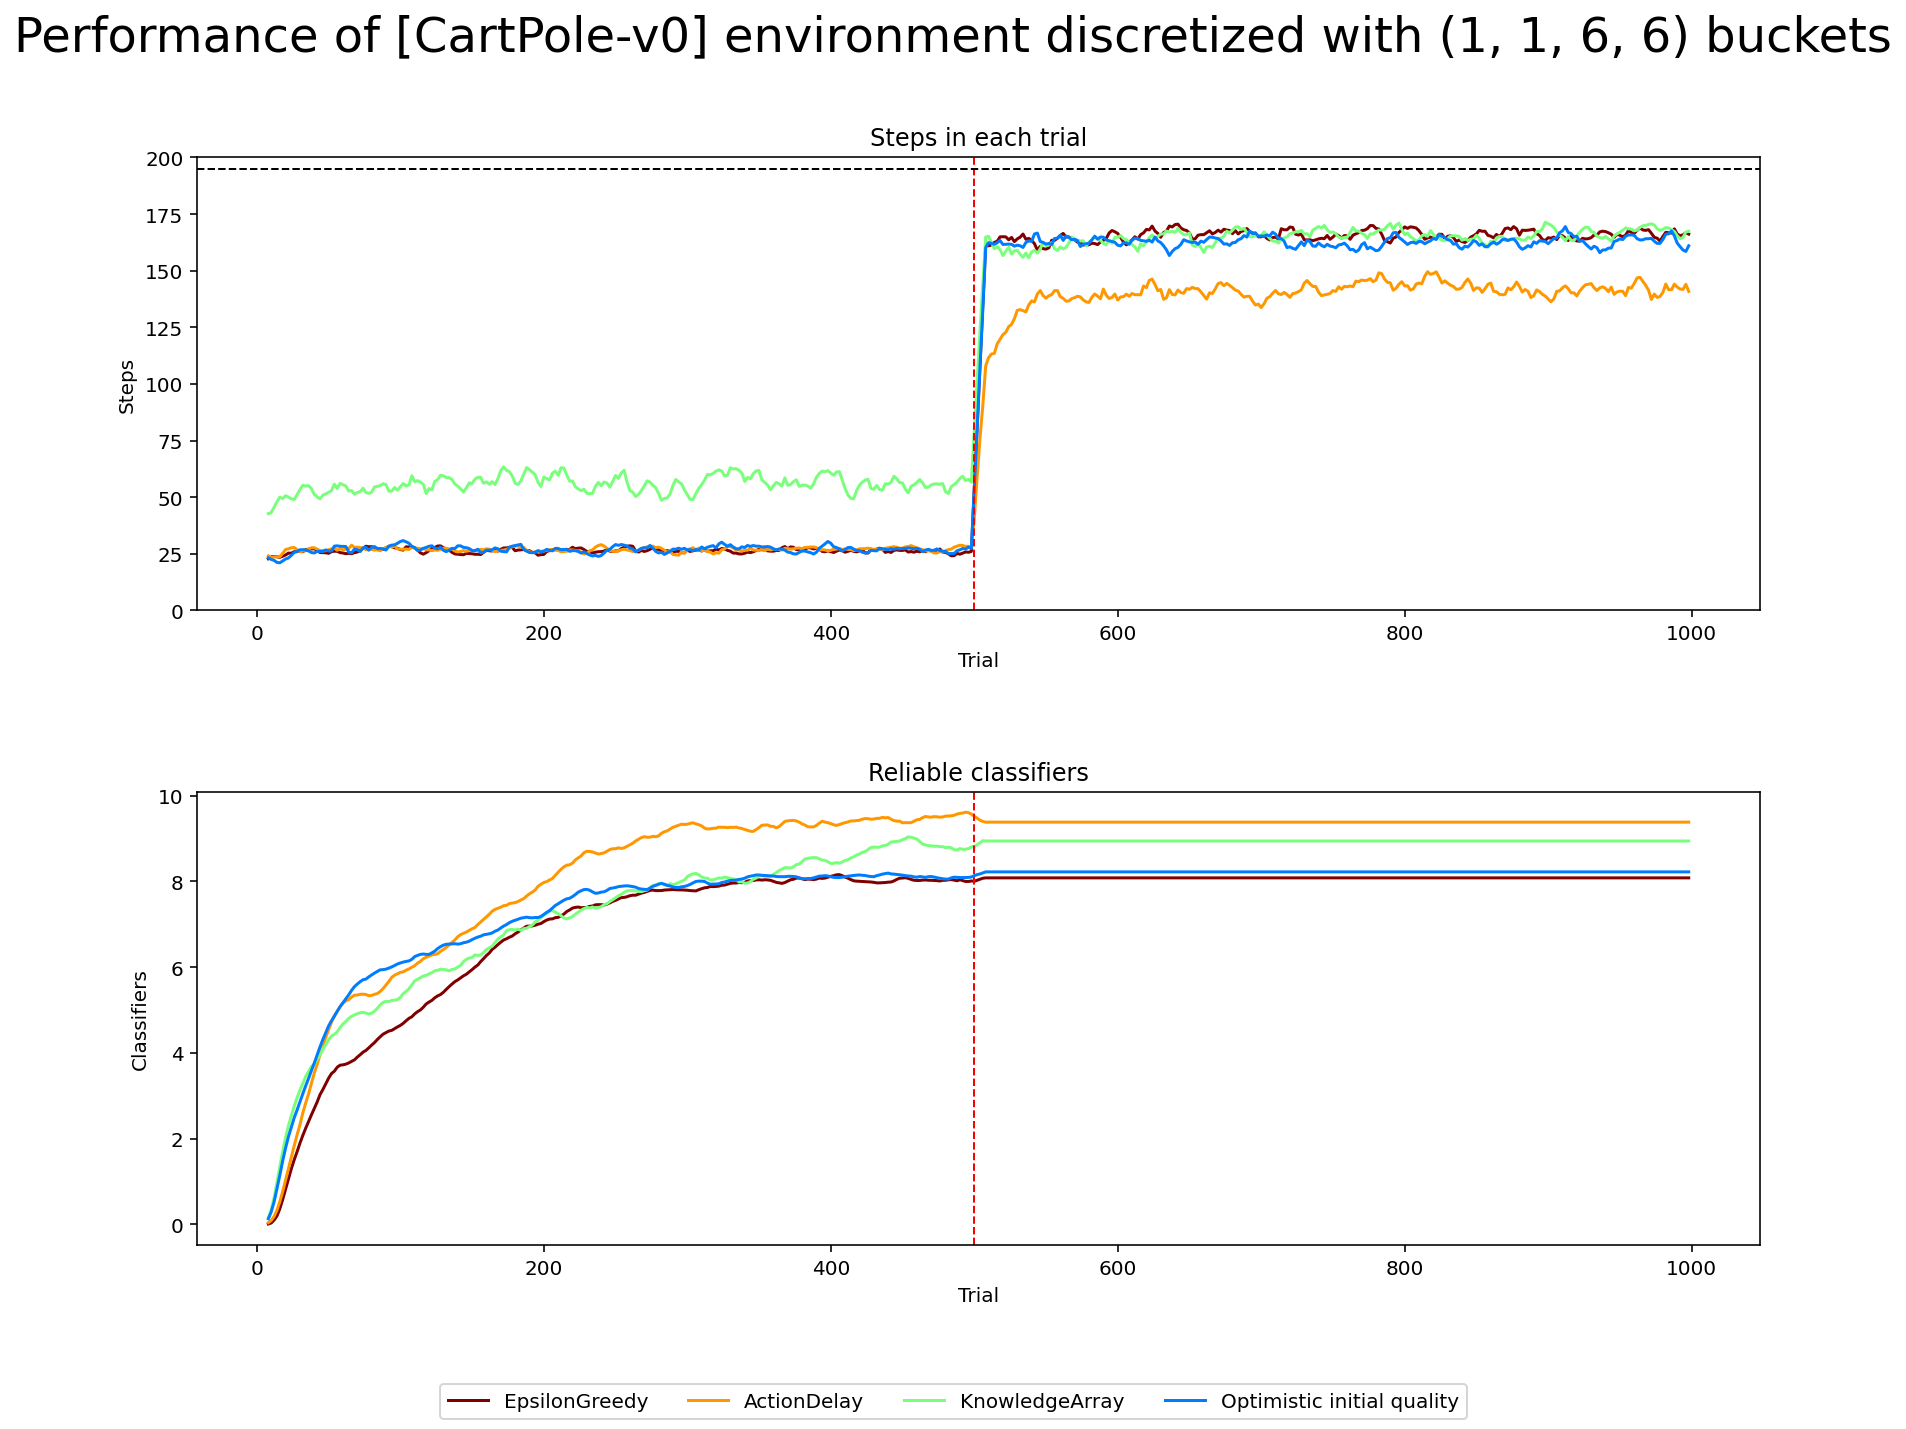

In [15]:
fig = plt.figure(figsize=(14, 10))

# Plots layout
gs = fig.add_gridspec(2,1, hspace=.4)
ax1 = fig.add_subplot(gs[0])
ax2 = fig.add_subplot(gs[1])

# Global title
fig.suptitle(f'Performance of [{env.unwrapped.spec.id}] environment discretized with {buckets} buckets', fontsize=24)

# Each axis
ma_window = 5  # moving average window

# Steps in trial
epsilon_greedy_df['steps_in_trial'].rolling(window=ma_window).mean().plot(label=epsilon_greedy_params['action_selector'].__name__, c=COLORS['eg'], ax=ax1)
action_delay_df['steps_in_trial'].rolling(window=ma_window).mean().plot(label=action_delay_params['action_selector'].__name__, c=COLORS['ad'], ax=ax1)
knowledge_array_df['steps_in_trial'].rolling(window=ma_window).mean().plot(label=knowledge_array_params['action_selector'].__name__, c=COLORS['ka'],ax=ax1)
op_initial_df['steps_in_trial'].rolling(window=ma_window).mean().plot(label='Optimistic initial quality', c=COLORS['oiq'], ax=ax1)

ax1.axvline(x=explore_trials, color='red', linewidth=1, linestyle="--")
ax1.axhline(y=195, color='black', linewidth=1, linestyle="--")

ax1.set_xlabel('Trial')
ax1.set_ylabel('Steps')
ax1.set_title(f'Steps in each trial')
ax1.set_ylim(0, 200)

# Population
epsilon_greedy_df['reliable'].rolling(window=ma_window).mean().plot(label=epsilon_greedy_params['action_selector'].__name__, c=COLORS['eg'], ax=ax2)
action_delay_df['reliable'].rolling(window=ma_window).mean().plot(label=action_delay_params['action_selector'].__name__, c=COLORS['ad'], ax=ax2)
knowledge_array_df['reliable'].rolling(window=ma_window).mean().plot(label=knowledge_array_params['action_selector'].__name__, c=COLORS['ka'], ax=ax2)
op_initial_df['reliable'].rolling(window=ma_window).mean().plot(label='Optimistic initial quality', c=COLORS['oiq'], ax=ax2)

ax2.axvline(x=explore_trials, color='red', linewidth=1, linestyle="--")

ax2.set_xlabel('Trial')
ax2.set_ylabel('Classifiers')
ax2.set_title(f'Reliable classifiers')

# Create legend
handles, labels = ax2.get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', ncol=4);

# Save plot to file
# fig.savefig('cartpole-performance.pdf')

## Classifiers lookup

In [16]:
cfg = Configuration(**base_params)
explorer = ACS2(cfg)

population_explore, metrics_explore = get_from_cache_or_run(
    f'{cache_prefix}/{ENV_NAME}-random-run.dill',
    lambda: explorer.explore(env, explore_trials))

In [17]:
reliable = [cl for cl in population_explore if cl.is_reliable()]
sorted(reliable, key=lambda cl: -cl.fitness)

[##32 1 ####             (00##)                q: 0.939 r: 3.294  ir: 0.9999 f: 3.092  exp: 889 tga: 13547 talp: 13549 tav: 16.9   num: 1,
 ##33 0 ####             (00##)                q: 0.947 r: 2.691  ir: 1.0    f: 2.548  exp: 1953 tga: 13529 talp: 13581 tav: 6.11   num: 1,
 ##22 1 ####             (00##)                q: 0.969 r: 2.49   ir: 1.0    f: 2.413  exp: 1816 tga: 13497 talp: 13557 tav: 6.53   num: 1,
 ##43 0 ####             (empty)               q: 0.988 r: 1.698  ir: 0.9983 f: 1.678  exp: 151 tga: 13537 talp: 13570 tav: 56.0   num: 20,
 ##12 1 ####             (empty)               q: 0.993 r: 1.338  ir: 0.9474 f: 1.328  exp: 240 tga: 13526 talp: 13559 tav: 52.2   num: 20,
 ##12 0 ####             (00##)                q: 0.969 r: 1.292  ir: 0.9534 f: 1.252  exp: 244 tga: 13524 talp: 13525 tav: 46.6   num: 1,
 ##43 1 ####             (00##)                q: 0.976 r: 1.269  ir: 0.9406 f: 1.239  exp: 183 tga: 13581 talp: 13581 tav: 49.7   num: 1]